# Structure

### [1. Preparation (reading the data)](#Preparation)

Needed:
* hCBCANH 4D spectrum of a target protein
* Assingment of HCBCANH file in TALOS format
* PACSY 

### [2. Creation of the grid over the peak and writing TALOS input files](#TALOS_inputs)
 [***Run TALOS predictions***](#Run)
### [3. Summarizing and displaying TALOS results](#TALOS_outputs)
### [4. Heterogeneity analysis](#Analysis)

-----------

# 1. Preparation

<a id='Preparation'></a>

In [59]:
wdir = "C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/" # Directory for TALOS grids, inputs and outputs and figures

## 1.1 Import libraries

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.ndimage import map_coordinates, center_of_mass 
from matplotlib.patches import Circle, PathPatch, Ellipse
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import matplotlib.transforms as transforms
import matplotlib as mpl
import nmrglue as nmr
import seaborn as sns
import os, glob

np.set_printoptions(precision=3)

In [4]:
print('numpy\tv.', np.__version__)
print('nmrglue\tv.', nmr.__version__)
print('pandas\tv.', pd.__version__)
print('seaborn\tv.', sns.__version__)
print('matplotlib\tv.', mpl.__version__)
print()
print("""Expected:
numpy\tv. 1.15.4
nmrglue\tv. 0.8
pandas\tv. 0.23.4
seaborn\tv. 0.9.0
matplotlib\tv. 3.0.2""")

numpy	v. 1.22.4
nmrglue	v. 0.9
pandas	v. 1.4.2
seaborn	v. 0.11.2
matplotlib	v. 3.5.2

Expected:
numpy	v. 1.15.4
nmrglue	v. 0.8
pandas	v. 0.23.4
seaborn	v. 0.9.0
matplotlib	v. 3.0.2


## 1.2 Definitions

### 1.2.1 Auxiliary

In [104]:
def shift(n, atom):
    return assignments.reset_index().set_index(['Num', 'Atom']).loc[num, atom]['Shift']

#A function to query a pandas.DataFrame
def query(df, columnname, value):
    return df.where(df[columnname]==value).dropna()

def cs_stat(residue, atom, sstr, pacsy_root=pacsy_root):
    ''' Reading information from a PACSY summary table (Fritzsching, K.J. et al, doi: 10.1007/s10858-016-0013-5)''' 
    
    PACSY_PLUQ_stats = pd.read_csv(os.path.join(pacsy_root, '/CS_STATS_DB.txt'),
                     names = 'Res Atom SndStr Mode Avg Min Max'.split(), index_col = False)
    #### PACSY_PLUQ_stats.sort_values('Atom', inplace = True)
    
    query_res = f'Res == "{residue}"'
    query_atom = f'Atom == "{atom}"'
    query_2str = f'SndStr == "{sstr}"'
    return PACSY_PLUQ_stats.query(query_res).query(query_atom).query(query_2str)

def coord_transform(arr1, limitsA=(0,1), limitsB=(-10,10)):
    '''Transforms points from space A to space B'''
    arr1 = np.asarray(arr1)
    return (limitsB[0]-limitsB[1])*(arr1-limitsA[0]) / (limitsA[0] - limitsA[1]) + limitsB[0]

### 1.2.2 Propensity correction

In [175]:
def scatter(peak_maximum, increment, spread): #spread is to be integer: it is the number of points to cover the peak area; increment determines the resolution
    if type(spread) is not int:
        print ("Number of points must be integer")
    points = [peak_maximum]

    for i in range(1, spread+1):
        points.append(round((peak_maximum + increment * i), 2)) # Here: 2 is for rounding up/down. Has nothing to do with number of points, dimensionality, etc!
    for i in range(1, spread+1):
        points.append(round((peak_maximum - increment * i), 2)) # Here: 2 is for rounding up/down. Has nothing to do with number of points, dimensionality, etc!
    points.sort()
    return (points)


def propensity_correction(residue, atom, fraction):
    '''Calculates the chemical shift of a given residue, which has the same 2ry structure propensity as the peak of interest, which is shifted by a "fraction"'''
    pure_H = cs_stat(residue, atom, 'H').Mode.values[0]
    pure_E = cs_stat(residue, atom, 'E').Mode.values[0]
    span = abs(pure_H-pure_E)
    rand_c = cs_stat(residue, atom, 'C').Mode.values[0]
    #rand_coil_shift = random_coil_shift_of_interest(residue, atom)
    #return rand_coil_shift + fraction*span
    return rand_c + fraction*span # Return chemical shift

### 1.2.3 Cutting a 4D box with the peak of interest

In [181]:
def slice4D(roi_num, width=(120, 25, 16, 16)): ### Useful for identifying a single peak! Good for plots!
    center_ppm = {}
    center_pts = {}
    assignments_local = assignments.reset_index().set_index(["Num", "Res", "Atom"])    
    for atom in ("HN", "CA", "N"):
        center_ppm[atom] = assignments_local.loc[roi_num, :, atom].values[0,0]
    try:
        center_ppm["CB"] = assignments_local.loc[roi_num, :, "CB"].values[0,0]
    except:
        center_ppm["CB"] = center_ppm["CA"]

    for atom in ("HN", "CA", "N", "CB"):
        ppm_limits = (dim_map.loc[dim_map["Atom"]==atom]["ppm_upfld"].values[0], dim_map.loc[dim_map["Atom"]==atom]["ppm_dwnfld"].values[0])
        pts_limits = (dim_map.loc[dim_map["Atom"]==atom]["pts_size"].values[0], 0)

        center_pts[atom] = coord_transform(center_ppm[atom], ppm_limits, pts_limits)
    
    idx = (slice( round(center_pts[dim_map.loc[0, "Atom"]])-width[0]//2, round(center_pts[dim_map.loc[0, "Atom"]])+width[0]//2, 1), 
           slice( round(center_pts[dim_map.loc[1, "Atom"]])-width[1]//2, round(center_pts[dim_map.loc[1, "Atom"]])+width[1]//2, 1),
           slice( round(center_pts[dim_map.loc[2, "Atom"]])-width[2]//2, round(center_pts[dim_map.loc[2, "Atom"]])+width[2]//2, 1),
           slice( round(center_pts[dim_map.loc[3, "Atom"]])-width[3]//2, round(center_pts[dim_map.loc[3, "Atom"]])+width[3]//2, 1) 
          )  
    cube = the_4D[idx] 
    return idx, cube

## 1.3 Reading data

In [68]:
sequence = 'SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA'

#### Path to the hCBCANH

Should be in .ucsf format. If not, change the `nmrglue FileIO` function accordingly

In [9]:
path_to_hCBCANH = "D:/Data/Hydrophobin/hCBCANH4d.ucsf"
#path_to_hCBCANH = "D:\PhD\Hydrophobin4Ds_Katja_12052020\spectra2\hCBCANH\hCBCANH4d.ucsf"

#### Path to the assignments

TALOS-formatted .tab file

In [6]:
path_to_assignments = 'D:/Data/Hydrophobin/Hydrophobin_4D_Assignments.tab'
#path_to_assignments = 'D:\PhD\Hydrophobin_4D_Assignments.tab'

#### Path to PACSY tables

**Created elsewhere (see `PACSY_analysis.ipynb`)**

Citations:
* [1]( https://doi.org/10.1007/s10858-012-9660-3) PACSY database
* [2]( https://doi.org/10.1007/s10858-016-0013-5) PIQC cleansing

In [183]:
pacsy_data = "C:/Users/Admin/sciebo/PACSY_PIQCed/"
pacsy_root = 'C:/Users/Admin/Documents/PACSY/pacsy_csv/zavot/data/whlee/pacsy/CSV_032822/' 

#### **Reading** (takes a while for the NMR data!)

In [13]:
form = path_to_hCBCANH.split('.')[-1]
if form == "ucsf":
    dic_4D, the_4D = nmr.sparky.read(path_to_hCBCANH)
    C = nmr.convert.converter()
    C.from_sparky(dic_4D, the_4D)
    dic_4D, the_4D  = C.to_pipe()
elif form == "ft":
    dic_4D, the_4D = nmr.pipe.read(path_to_hCBCANH)
else:
    print ("Format not detected. Please, check and update file extention accordingly")

In [17]:
print(f'''Obs. freq. order:\t4 {dic_4D["FDF4OBS"]} MHz
                        3 {dic_4D["FDF3OBS"]} MHz
                        2 {dic_4D["FDF2OBS"]} MHz
                        1 {dic_4D["FDF1OBS"]} MHz

Often does not reflect the real order of dimensions - always double-check!!!''')

Obs. freq. order:	4 700.1749877929688 MHz
                        3 176.0679931640625 MHz
                        2 176.0679931640625 MHz
                        1 70.95600128173828 MHz

Often does not reflect the real order of dimensions - always double-check!!!


#### Dimension mapping - **MANUAL INTERVENTION**

Establish correct mapping of the dataset (i.e. spectrum) dimensions to the 1) atoms; 2) axes IDs (from the spectrum header, which is currently written into `dic_4D` ). This is necessary to make sure the spectrum is correctly read and plotted

In [150]:
                #NumPy dimension: #Atom; #Axis ID; limits in ppm  ; size of dimension in points
    
dim_map = pd.DataFrame(index=['Atom', 'Axis', "ppm_dwnfld", "ppm_upfld", "pts_size"], 
                       data = {
                                0: ("HN",  "f4",  10.595,   5.536, the_4D.shape[0]),          ###### Correct here if needed
                                1: ("CA",  "f3",  85.22,    6.39,  the_4D.shape[1]),          ###### Correct here if needed
                                2: ("N",   "f2", 135.72,  100.13,  the_4D.shape[2]),          ###### Correct here if needed
                                3: ("CB",  "f1",  71.99,   19.44,  the_4D.shape[3]),          ###### Correct here if needed
                              })   
dim_map = dim_map.transpose()
dim_map

,Atom,Axis,ppm_dwnfld,ppm_upfld,pts_size
0,HN,f4,10.595,5.536,174
1,CA,f3,85.22,6.39,128
2,N,f2,135.72,100.13,128
3,CB,f1,71.99,19.44,128


#### Define the min and max ppm at spectrum borders 

In [18]:
f4_ppm_lims = (10.595, 5.536) 
f1_ppm_lims = (85.22, 6.39)
f3_ppm_lims = (71.99, 19.44)
f2_ppm_lims = (135.72, 100.13)

f4_axis = 'HN'
f3_axis = 'CA' 
f2_axis = 'N'
f1_axis = 'CB'

limits_ppm = {f4_axis: f4_ppm_lims, 
             f3_axis: f3_ppm_lims,
             f2_axis: f2_ppm_lims,
             f1_axis: f1_ppm_lims}

limits_points = [(0,x) for x in the_4D.shape]

In [61]:
# Assignments

assignments = pd.read_csv(path_to_assignments, header=None, index_col=0, names=['Num', 'Res', 'Atom', 'Shift'], delim_whitespace=True)

#### Visual check of the spectrum

Compare with CCPN

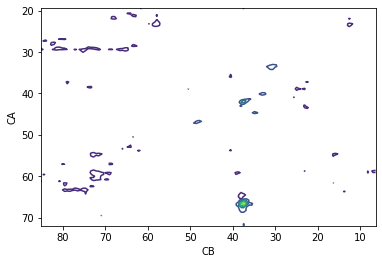

In [129]:
### CACB plane
##

extent=(dim_map.loc[1, "ppm_upfld"], dim_map.loc[1, "ppm_dwnfld"], 
        dim_map.loc[3, "ppm_upfld"], dim_map.loc[3, "ppm_dwnfld"])

plt.contour(the_4D[105, :, 67, :].T, extent=extent)
#plt.contour(the_4D[35, :, 43, :].T, extent=extent)
#35 - 79 - 43 - 56
#plt.gca().set_aspect(0.5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(dim_map.loc[3,"Atom"])
plt.ylabel(dim_map.loc[1,"Atom"])
plt.show()

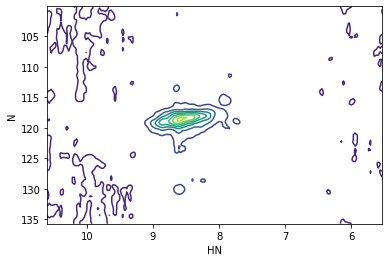

In [127]:
### HN plane
extent=(dim_map.loc[0, "ppm_upfld"], dim_map.loc[0, "ppm_dwnfld"], 
        dim_map.loc[2, "ppm_upfld"], dim_map.loc[2, "ppm_dwnfld"])

plt.contour(the_4D[:, 51, :, 115].T, extent=extent)
#plt.contour(the_4D[:, 79, :, 56], extent=extent)
#35 - 79 - 43 - 56
#plt.gca().set_aspect(8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(dim_map.loc[0,"Atom"])
plt.ylabel(dim_map.loc[2,"Atom"])
plt.show()

# 2. Writing TALOS inputs

<a id='TALOS_inputs'></a>

In [52]:
print("Positions of Glycines in the sequence: \n", assignments.where(assignments.Res == 'G').dropna().index.unique().values)

Positions of Glycines in the sequence: 
 [25 30 34 41 55]


**Residue of interest:**

In [57]:
roi_num = 53

In [58]:
roi_type = assignments.loc[num]['Res'].unique()[0]
if roi_type == "G":
    print(f'Residue\t {num}{roi_type}\n\n {assignments.loc[num]}\n\nEligible?\t{("N" in assignments.loc[num]["Atom"].values) & ("CA" in assignments.loc[num]["Atom"].values) }')
else:
    print(f'Residue\t {num}{roi_type}\n\n {assignments.loc[num]}\n\nEligible?\t{("CB" in assignments.loc[num]["Atom"].values) & ("CA" in assignments.loc[num]["Atom"].values) & ("N" in assignments.loc[num]["Atom"].values) }')

Residue	 41G

     Res Atom    Shift
Num                  
41    G    C  172.429
41    G   CA   44.499
41    G   HN    7.344
41    G    N  105.514

Eligible?	True


## 2.1. Creating the grid for TALOS

### 2.1.1 Grid parameters

In [53]:
f4_incr = 0.4 #float(input('Set the resolution of the grid in F1 dimension (ppm): ')) #1H
f4_spread = 3 #int(input("Set the number of grid's points around maximum in F1 dimension: "))

f3_incr = 0.4 #float(input('Set the resolution of the grid in F3 dimension (ppm): ')) #13Ca
f3_spread = 3 #int(input("Set the number of grid's points around maximum in F3 dimension: "))

f2_incr = 0.75 #float(input('Set the resolution of the grid in F2 dimension (ppm): ')) #15N
f2_spread = 3 #int(input("Set the number of grid's points around maximum in F2 dimension: "))

f1_incr = 0.75 #float(input('Set the resolution of the grid in F4 dimension (ppm): ')) #13Cb
f1_spread = 2 #int(input("Set the number of grid's points around maximum in F4 dimension: "))

### 2.1.2 Writing the grid into a data frame

`peak_box` contains the grid

In [54]:
### Defining center of the peak by the peak maximum (taking from the assignments)
if roi_type=='G':
    peak_center = np.array([shift(roi_num, dim_map.loc[0, "Atom"]), shift(roi_num, dim_map.loc[1, "Atom"]), shift(roi_num, dim_map.loc[2, "Atom"]), shift(roi_num, dim_map.loc[1, "Atom"])]).reshape(4,1)
else:
    peak_center = np.array([shift(roi_num, dim_map.loc[0, "Atom"]), shift(roi_num, dim_map.loc[1, "Atom"]), shift(roi_num, dim_map.loc[2, "Atom"]), shift(roi_num, dim_map.loc[3, "Atom"])]).reshape(4,1)

## Or enter the coordinates manually (may be better in the case of skewed peaks)
#peak_center = np.array([8.655, 52.694, 123.86, 17.613]).reshape(4,1)

peak_cent=transform(peak_center, list(limits_ppm.values()), limits_points) # double-check with CCPN v.2.** if the points coordinates are correct
peakmax=map_coordinates(the_4D, peak_cent, order=1)

In [55]:
import time
start=time.time()

scattered_f1 = scatter(float(peak_center[3]), f1_incr, f1_spread)
scattered_f2 = scatter(float(peak_center[2]), f2_incr, f2_spread)
scattered_f3 = scatter(float(peak_center[1]), f3_incr, f3_spread)
scattered_f4 = scatter(float(peak_center[0]), f4_incr, f4_spread)

peak_box = pd.DataFrame()
CO_shift = shift(num, 'C')
#peak_box = np.meshgrid(scattered_f1, scattered_f2, scattered_f3, scattered_f4)

for ppm_f4 in scattered_f4:
    for ppm_f3 in scattered_f3:
        for ppm_f2 in scattered_f2:
            for ppm_f1 in scattered_f1:
                
                coord=np.array([ppm_f4, ppm_f3, ppm_f2, ppm_f1])
                coord=coord.reshape(4,1)
                coord_points = transform(coord, list(limits_ppm.values()), limits_points)
                intensity = map_coordinates(the_4D, coord_points, order=1)
                new_line = pd.DataFrame(data=[[ppm_f4, ppm_f3, ppm_f2, ppm_f1, CO_shift, intensity[0]]], columns=['f4_H', 'f3_CA', 'f2_N', 'f1_CB', 'C', 'Intensity'])
                peak_box = pd.concat((peak_box, new_line), ignore_index=True)

#Cutting off the points in the noise (Here: that are less than 15% of intensity of the peak maximum)

peak_box = peak_box.where(peak_box['Intensity'] > peakmax[0]*0.15).dropna()
peak_box.reset_index(drop=True, inplace=True)
                
finish = time.time()
print(f'Run took {finish-start} s')
print(f'Number of grid points: {len(peak_box)}')

Run took 0.9225246906280518 s
Number of grid points: 197


#### **WRITE the grid into a file**

In [60]:
flag = input("Write the grid for  in the file? (Y/N)")
if flag == "Y": 
    peak_box.to_csv(wdir+f"PeakShapes/{roi_num}{roi_type}.csv", sep="\t")
    print("The grid is saved as", wdir+f"PeakShapes/{roi_num}{roi_type}.csv")
else:
    print("Nothing is written")
flag="N"

Write the grid for  in the file? (Y/N) N


Nothing is written


### Visual check: grid

#### **LOAD the grid from a checkpoint**: 

<a id='CP 1'></a>

In [99]:
roi_num = 63
roi_type = assignments.loc[roi_num]['Res'].unique()[0]

print(roi_num,roi_type)

peak_box = pd.read_csv(wdir+f"PeakShapes/{roi_num}{roi_type}.csv", sep='\t',  index_col=0)

# Reading the PIQCed PACSY tables

if roi_type=='G':
    pacsy = pd.read_csv(f'{pacsy_data}/G_HNCACo_PIQCed.csv')
    proj = the_4D.sum(axis=tuple(proj_dims))
else:
    pacsy = pd.read_csv(f'{pacsy_data}/{roi_type}_HNCACB_PIQCed.csv')     # reading the arranged table that we generated in GGAGG PACSY analysis.ipynb
    proj = the_4D.sum(axis=tuple(proj_dims))

63 A


In [102]:
# Set axes and contour levels (for protons need to abjust ppm limits!)

x='CB'
y='CA'
if roi_type == 'G':
    x = 'CA'
    y = 'N'

base_lvl = 0.20 ## For NCA projections (Gly)
base_lvl = 0.05 ## For CBCA projections (Gly)
n_lvl = 18
factor = 1.1

#### Superimposed grid, spectrum and the PACSY data

Figure saved as C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/63A.png


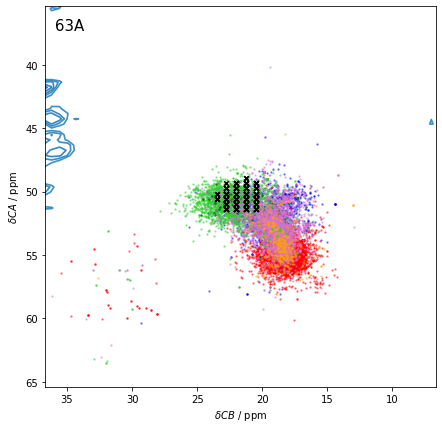

In [103]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))

peak_box = pd.read_csv(wdir+f"PeakShapes/{roi_num}{roi_type}.csv", sep='\t',  index_col=0)
peak_box.columns = ["H", "CA", "N", "CB", "C", "Intensity"]

cl_neg = [-1*base_lvl * factor ** x for x in range(n_lvl)]
cl_neg.reverse()
cl_pos = [base_lvl * factor ** x for x in range(n_lvl)]
cl = cl_neg + cl_pos
norm = mpl.colors.Normalize(vmin=cl[5],vmax=cl[-5])

proj_dims=[0,1,2,3]
proj_dims.remove(dim_map.index[dim_map['Atom']==x].values[0])
proj_dims.remove(dim_map.index[dim_map['Atom']==y].values[0])

proj = the_4D.sum(tuple(proj_dims))
proj = proj/proj.max()

###############################################################
#### Plot the newly created projection ########################

ax.contour(proj.T, np.array(cl),
            extent = (limits_ppm[x][0], limits_ppm[x][1], limits_ppm[y][0], limits_ppm[y][1]), 
            cmap = 'Blues', alpha=1, norm=norm,
            linewidths=1.7, zorder=2)

###############################################################
########## Plot PACSY data ####################################

groups = pacsy.groupby("2strSTRIDE")

colors={"B": "darkgreen", 
        "C": "blue",
        "E": "limegreen",
        #"G": "purple",
        "G": "orange",
        "H": "red",
        #"I": "darkorange",
        "I": "black",
        "b": "mediumseagreen",
        "T": "orchid"}

names = ["C", "H", "E", "B", "T", "G", "I",  "b"]

for name in names:
    #ax.scatter(group['CB'], group['CA'], c=colors[i], marker="o", s=3, label=name, alpha=0.5)
    try:
        group = groups.get_group(name=name)
    except KeyError:
        pass
    if name == "I":
        ax.scatter(group[x], group[y], c=colors["G"], marker="o", s=2, alpha=0.9)
    elif name == "b":
        ax.scatter(group[x], group[y], c=colors["E"], marker="o", s=2, alpha=0.9)
    elif name == "B":
        ax.scatter(group[x], group[y], c=colors["B"], marker="o", s=2, label=name, alpha=0.3)
        ax.scatter(group[x], group[y], c=colors["B"], marker="o", s=2, alpha=0.3)
        ax.scatter(group[x], group[y], c=colors["B"], marker="o", s=2, alpha=0.3)
    else:
        ax.scatter(group[x], group[y], c=colors[name], marker="o", s=2, label=name, alpha=0.4)
    #peak_regions[name]=group

################################################################
#### Plot the gridpoints (those will be subjected to TALOS) ####

#ax.scatter(x=peak_box.filter(like=x, axis=1), y=peak_box.filter(like=y, axis=1), c='black', marker='x', s=20, zorder=3)
ax.scatter(x=peak_box[x], y=peak_box[y], c='black', marker='x', s=20, zorder=3)

###############################################################

ax.set_xlim(peak_box[x].mean()+15,peak_box[x].mean()-15)
ax.set_ylim(peak_box[y].mean()+15,peak_box[y].mean()-15)

#ax.set_xlabel('$\delta^{13}C$ / ppm')
#ax.set_ylabel('$\delta^{13}C$ / ppm')
ax.set_xlabel(f'$\delta {x}$ / ppm')
ax.set_ylabel(f'$\delta {y}$ / ppm')

#ax.text(x=27, y=57.8, s='4D limits', transform=    
ax.text(0.1, 0.95, s=f'{roi_num}{roi_type}', va='center', ha='right', fontsize=15,
            transform=ax.transAxes)
#ax.text(x=27, y=58.4, s=f'{limits_ppm}')
fig.savefig(wdir+f'{roi_num}{roi_type}.png', format='png', dpi=300)
print("Figure saved as", wdir+f'{roi_num}{roi_type}.png')
plt.show()

> Is S26 one peak or are these two???
C40 and C46 occur in between oxidized and redused densities - sus!

>Why doesn't it overlay with PACSY well?
Referencing?!

>In cases like this, the "PACSY method" clearly is not an option!  --- how many points are needed to have "enough" for statistics??

In [133]:
### peak_box.columns = ["f4", "f3", "f2", "f1", 'C', "Intensity"]
peak_maximum = peak_box[peak_box['Intensity']==peak_box['Intensity'].max()]

#### **WRITE the grid into a file**

In [60]:
flag = input("Write the grid for  in the file? (Y/N)")
if flag == "Y": 
    peak_box.to_csv(wdir+f"PeakShapes/{roi_num}{roi_type}.csv", sep="\t")
    print("The grid is saved as", wdir+f"PeakShapes/{roi_num}{roi_type}.csv")
else:
    print("Nothing is written")
flag="N"

Write the grid for  in the file? (Y/N) N


Nothing is written


## 1.2 Writing the series of inputs for TALOS for the given residue of interest

In [194]:
roi_type = assignments.loc[num]['Res'].unique()[0]

In [136]:
peak_maximum[['f4', 'f3', 'f2', 'C']].values.ravel()

array([  7.344,  44.499, 105.514, 172.429])

### 1.2.1 **Neighbor correction**

In [196]:
try:
    os.mkdir(os.path.join(wdir, f'_1/TALOS_inputs_{roi_num}{roi_type}')) # Create the folder with inputs in the current directory
except:
    pass

start=time.time()

template = assignments.copy()

peak_box.columns = ['H', 'CA', 'N', 'CB', 'C', 'Intensity']

i = 0

span_residue_of_interest={}

# Calculate the span of chemical shifts (here: difference between chem. shifts of helical and sheet-like structures) 
# for the residue of interest. Chemical shift distributions are taken from PACSY database.
for atom in ["HN", "CA", "N", "CB", 'C']:
    try:
        span_residue_of_interest[atom] = (cs_stat(roi_type, atom, 'H').Mode.values[0] - cs_stat(roi_type, atom, 'E').Mode.values[0]).round(2)
    except IndexError:
        try:
            span_residue_of_interest[atom] = (cs_stat(roi_type, 'H', 'H').Mode.values[0] - cs_stat(roi_type, 'H', 'E').Mode.values[0]).round(2)
        except KeyError:
            print("Something is deeply wrong")

if roi_type == 'G':
    limits_residue_of_interest = [(cs_stat(roi_type, atom, 'H').Mode.values[0], cs_stat(roi_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'C']]
else:    
    limits_residue_of_interest = [(cs_stat(roi_type, atom, 'H').Mode.values[0], cs_stat(roi_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'CB', 'C']]

mimic_peak_shapes = {}

for neigh_num in [num-2, num-1, num+1, num+2]: #For each neighbour's number:
    for 
        neigh_type = template.loc[neigh_num]['Res'].unique()[0] # get its residue type
        if restype == 'G':
            limits_neighbouring_residue = [(cs_stat(neigh_type, atom, 'H').Mode.values[0], cs_stat(neigh_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'C']]
            data = coord_transform(peak_box[['H', 'CA', 'N', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
            neighbor_box = pd.DataFrame(data, columns=['H', 'CA', 'N', 'C'])
        else:
            limits_neighbouring_residue = [(cs_stat(neigh_type, atom, 'H').Mode.values[0], cs_stat(neigh_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'CB', 'C']]
            if roi_type == 'G':
                
                data = transform(peak_box[['H', 'CA', 'N', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
                ##################data  ########
                limits_neighbouring_residue = [(cs_stat(roi_type, atom, 'H').Mode.values[0], cs_stat(roi_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'C']]

                data = coord_transform(peak_box[['H', 'CA', 'N', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T

                neighbor_box = pd.DataFrame(data, columns=['H', 'CA', 'N', 'C'])
                neighbor_box['CB'] = ((neighbor_box['CA'] - cs_stat(neigh_type, 'CA', 'H').Mode.values[0]) * 
                          (cs_stat(neigh_type, 'CB', 'H').Mode.values[0] - cs_stat(neigh_type, 'CB', 'E').Mode.values[0]) / 
                          (cs_stat(neigh_type, 'CA', 'H').Mode.values[0] - cs_stat(neigh_type, 'CA', 'E').Mode.values[0])
                          + cs_stat(neigh_type, 'CB', 'H').Mode.values[0])
            else:
                data = coord_transform(peak_box[['H', 'CA', 'N', 'CB', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
                neighbor_box = pd.DataFrame(data, columns=['H', 'CA', 'N', 'CB', 'C'])

        mimic_peak_shapes[neigh_num] = neighbor_box

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

### 1.2.2 Writing the data on disk

In [ ]:
sample_every_Nth_point=1 # SAMPLE EVERY 3rd POINT ??

for i in range(0, len(peak_box), sample_every_Nth_point): 

    subj = template.copy()
    subj.set_index('Atom', append=True, inplace=True)
    
    subj.at[(roi_num, 'HN'), 'Shift'] = peak_box.at[i, 'H'].round(2)
    subj.at[(roi_num, 'CA'), 'Shift'] = peak_box.at[i, 'CA'].round(2)
    subj.at[(roi_num, 'N'), 'Shift'] = peak_box.at[i, 'N'].round(2)
    try: 
        subj.at[(roi_num, 'C'), 'Shift'] = peak_box['C'].round(2)
    except: 
        pass

    if restype != 'G':
        subj.at[(roi_num, 'CB'), 'Shift'] = peak_box.at[i, 'CB'].round(2)

    for neigh_num in [num-2, num-1, num+1, num+2]:
        
        restype = subj.loc[neigh_num]['Res'].unique()[0] # get its residue type

        subj.at[(neigh_num, 'HN'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'H'].round(2)
        subj.at[(neigh_num, 'N'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'N'].round(2)
        subj.at[(neigh_num, 'CA'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'CA'].round(2)
        try: 
            subj.at[(neigh_num, 'C'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'C'].round(2)
        except: 
            pass
        if restype != 'G':
            #subj.at[template.loc[(template[0] == neigh_num) & (template[2] == 'CB')].index[0], 3]  = mimic_peak_shapes[neigh_num].at[i, 'CB'].round(2)
            subj.at[(neigh_num, 'CB'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'CB'].round(2)
    
    fname = os.path.join(wdir, f'TALOS_inputs_{num}{roi_type}', str(i)+'.tab')
    subj.set_index('Res', append=True).reorder_levels(['Num', 'Res', 'Atom']).to_csv(fname, sep = ' ', header=None) 
    
    ### WRITE THE FILES ###
    with open(fname, 'r') as original: 
        data = original.read()
    with open(fname, 'w') as modified: # ...then write to this file the preamble and everything that was in the file before
        modified.write(f'''REMARK EASd15 {num}{roi_type} series

DATA FIRST_RESID 1

DATA SEQUENCE {sequence}

VARS   RESID RESNAME ATOMNAME SHIFT
FORMAT %4d   %1s     %4s      %8.3f
{data}''')
        
finish = time.time()
print(f'The run took {round(finish-start, 1)} s')
print(str(len(glob.glob(os.path.join(wdir, f'_1/TALOS_inputs_{roi_num}{roi_type}', '*.tab')))) + ' files were written')

# Now run TALOS with all these files.

<a id='Run'></a>

-------

# 3. Reading and visualizing TALOS predictions

<a id='TALOS_outputs'></a>
## 3.1 Preparations
### 3.1.1 Definitions

In [244]:
def pred_dict(path_to_predABP):
    data_raw = []
    with open(path_to_predABP, 'r') as pred:
        for l_no, line in enumerate(pred):
            if l_no>29: 
                data_raw.append(line)

    predictions = {}

    for line in data_raw:
        _ = line.split()
        res_code = _[0] + _[1]
        predictions[res_code] = np.array([float(x) for x in _[6:]])
    return predictions

def run_id(abs_path):
    run_id = abs_path.split(sep='_')[-1].split(sep='//')[0].split(sep='.')[0]
    return run_id

### 3.1.2 Paths

In [259]:
roi_num = 53 # Number of the residue of interest 

In [266]:
sequence = 'SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA'
wdir = 'C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/' 
talos_outputs = os.path.join(wdir, 'Results natural') + f'/{roi_num}{roi_type}/*/predABP.tab'

In [267]:
paths = talos_outputs
number_of_TALOS_outputs = len(glob.glob(paths))
print("Number of TALOS outputs in the directory", number_of_TALOS_outputs)

Number of TALOS outputs in the directory 173


> 54, 28 - a lot of inputs! Check if the predictions are complete

#### Reading the data

In [268]:
assignments = pd.read_csv(path_to_assignments, header=None, index_col=0, names=['Num', 'Res', 'Atom', 'Shift'], delim_whitespace=True)
roi_type = assignments.loc[roi_num]['Res'].unique()[0]
peak_box = pd.read_csv(os.path.join(wdir, f'PeakShapes/{roi_num}{roi_type}.csv'), sep='\t', index_col=0)

print(roi_num,roi_type)

53 N


In [269]:
number_of_TALOS_inputs = len(glob.glob(wdir + f'TALOS_inputs_{roi_num}{roi_type}/*.tab'))

print('Predictions complete:', number_of_TALOS_outputs == number_of_TALOS_inputs)
print('Prediction missing for ' + str(number_of_TALOS_inputs - number_of_TALOS_outputs) + ' points')

Predictions complete: True
Prediction missing for 0 points


## 3.2 Plotting
### 3.2.1 Looking at particular points
We want to look at Ramachandran maps of a. the peak maximum; b. most "helical" propencity; c. the most "sheet-like" one

#### 1. Peak maximum

In [233]:
idM = peak_box.Intensity.idxmax()

print('Peak maximum is the point #', idM)

Peak maximum is the point # 103


In [234]:
peak_box.loc[peak_box.Intensity.idxmax()]

f4           9.003000e+00
f3           5.216100e+01
f2           1.230670e+02
f1           4.059500e+01
C            1.730960e+02
Intensity    3.673741e+09
Name: 103, dtype: float64

In [190]:
dim_map

,Atom,Axis,ppm_dwnfld,ppm_upfld,pts_size
0,HN,f4,10.595,5.536,174
1,CA,f3,85.22,6.39,128
2,N,f2,135.72,100.13,128
3,CB,f1,71.99,19.44,128


#### 2. "Helical" point: 13Cb MINIMUM -> 13Ca MAXIMUM possible -> 15N MIN possible

In [235]:
first_selection = peak_box.where(peak_box['f1'] == peak_box['f1'].min()).dropna()
second_selection = first_selection.where(first_selection['f3'] == first_selection['f3'].max()).dropna()
third_selection = second_selection.where(second_selection['f2'] == second_selection['f2'].min()).dropna()
helical_point = third_selection.where(third_selection['f4'] == third_selection['f4'].min()).dropna()
idH = helical_point.index[0]
helical_point

,f4,f3,f2,f1,C,Intensity
131,9.003,52.56,123.82,39.09,173.096,612715008.0


#### 3. "Sheety" point: 13Cb MAXIMUM -> 13Ca MINIMUM possible -> 15N MAX possible

In [237]:
first_selection = peak_box.where(peak_box['f1'] == peak_box['f1'].max()).dropna()
second_selection = first_selection.where(first_selection['f3'] == first_selection['f3'].min()).dropna()
third_selection = second_selection.where(second_selection['f2'] == second_selection['f2'].max()).dropna()
sheety_point = third_selection.where(third_selection['f4'] == third_selection['f4'].max()).dropna()
idE = sheety_point.index[0]
#sheety_points = peak_of_interest.where(peak_of_interest['f1'] == peak_of_interest['f1'].max()-0.4).dropna().where(peak_of_interest['w2'] < peak_of_interest['w2'].min()+0.8).dropna()
sheety_point

,f4,f3,f2,f1,C,Intensity
59,9.003,51.36,123.067,42.09,173.096,579914624.0


Or select points manually:

In [295]:
"""first_selection = peak_of_interest.where(peak_of_interest['w4'] == 23.610).dropna()
second_selection = first_selection.where(first_selection['w2'] == 51.690).dropna()
sheety_point_old = second_selection.where(second_selection['w3'] == 123.86).dropna()
sheety_point_old = sheety_point_old.where(sheety_point_old['w1'] == 9.460).dropna()

#sheety_points = peak_of_interest.where(peak_of_interest['w4'] == peak_of_interest['w4'].max()-0.4).dropna().where(peak_of_interest['w2'] < peak_of_interest['w2'].min()+0.8).dropna()
sheety_point_old"""

"first_selection = peak_of_interest.where(peak_of_interest['w4'] == 23.610).dropna()\nsecond_selection = first_selection.where(first_selection['w2'] == 51.690).dropna()\nsheety_point_old = second_selection.where(second_selection['w3'] == 123.86).dropna()\nsheety_point_old = sheety_point_old.where(sheety_point_old['w1'] == 9.460).dropna()\n\n#sheety_points = peak_of_interest.where(peak_of_interest['w4'] == peak_of_interest['w4'].max()-0.4).dropna().where(peak_of_interest['w2'] < peak_of_interest['w2'].min()+0.8).dropna()\nsheety_point_old"

#### max, H and E together:

In [238]:
peak_box.loc[[idM, idH, idE]]

,f4,f3,f2,f1,C,Intensity
103,9.003,52.161,123.067,40.595,173.096,3.673741e+09
131,9.003,52.560,123.820,39.090,173.096,6.127150e+08
59,9.003,51.360,123.067,42.090,173.096,5.799146e+08


#### Now plot the selected points:

Text(0.5, 1.0, 'Most E   Int. = 0.16')

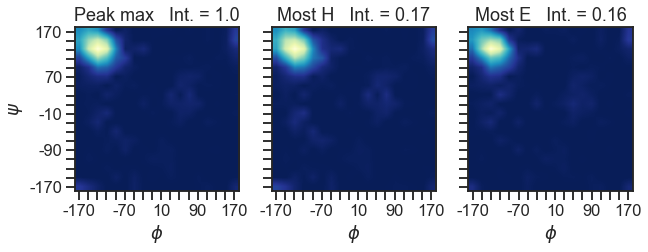

In [270]:
sns.set_context("talk")
sns.set_style("ticks")

queries = [idM, idH, idE]
list_of_experiments = []

# first point: closest to absolute maximum; 2nd: 'helical', 3rd: 'sheet'

list_of_all_experiments = glob.glob(paths)
#list_of_experiments = random.choices(list_of_all_experiments, k=10)
for i in queries:
    list_of_experiments.append(list_of_all_experiments[0].replace('pred_0', f'pred_{str(i)}'))

seq_lbls = [f'{roi_num}{roi_type}']
dict_full = pred_dict(list_of_experiments[0])
dic_to_plot = {res: dict_full[res] for res in seq_lbls}

fig, axs = plt.subplots(1, 3, figsize=(10,10))
#fig.suptitle('Hydrophobin\n ' + f'{roi_num} {roi_type}' + ' changes its chemical shift', y=0.943, fontsize=14)

xticks = np.arange(18) 
x_lbls = [-170, None, None, None, None, -70,  None, None, None, 10, None, None, None, 90, None, None, None, 170]
yticks = np.arange(18)
y_lbls = [170, None, None, None, None, 70,  None, None, None, -10, None, None, None, -90, None, None, None, -170]

i=0
j=0

images = []

for path in list_of_experiments:
    dic_full = pred_dict(path)
    dic = {res: dic_full[res] for res in seq_lbls}
    i=0
    for res in dic:
        distr = np.asarray(dic[res])
        distr = distr.reshape(18, 18)
        images.append(axs[j].imshow(np.rot90(distr, 1), cmap='YlGnBu_r', interpolation='bilinear', alpha=1))#, interpolation='bilinear'))
        
        axs[j].set_xticks(xticks) # positions
        axs[j].set_xticklabels(x_lbls)
        axs[j].set_yticks(yticks) # positions
        axs[0].set_yticklabels(y_lbls)
        axs[j].set_xlabel("$\phi$") 
        axs[j].set_ylabel("$\psi$")
        #axs[j].set_title(path.split(sep='_')[-1].split(sep='//')[0].split(sep='.')[0], fontsize=14)
        #axs[j].set_title(run_id(path)+'   Int. = '+ str(round(peak_of_interest.loc[int(run_id(path))].Data / peak_of_interest.Data.max(),2)))
    
        axs[j].label_outer()
        #print(i, j, res, path)
    j+=1    

    
axs[0].set_title('Peak max'+'   Int. = '+ str(round(peak_box.loc[idM].Intensity / peak_box.Intensity.max(),2)))
axs[1].set_title('Most H'+'   Int. = '+ str(round(peak_box.loc[idH].Intensity / peak_box.Intensity.max(),2)))
axs[2].set_title('Most E'+'   Int. = '+ str(round(peak_box.loc[idE].Intensity / peak_box.Intensity.max(),2)))

#fig.tight_layout()

###fig.savefig(f'{wdir}/{roi_num}{roi_type}_selection.png', format='png', dpi=600)
#====================================================================================

#### **Summary map**

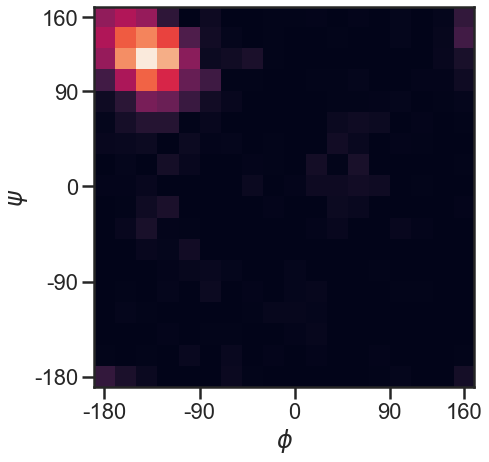

In [272]:
list_of_experiments = glob.glob(paths)
##dic = tl.get_working_dic(list_of_experiments[0])
dic = pred_dict(list_of_experiments[0])

sns.set_context("poster")
sns.set_style("ticks")

list_of_predictions = []
list_of_weights = []

for path in list_of_experiments:
    dic = pred_dict(path) ## Reading TALOS prediction data
    list_of_predictions.append(dic) 
    list_of_weights.append(peak_box["Intensity"][int(run_id(path))]) ## Lookup number of TALOS run and find intensity of the corresponding point 
    
result = {}
i=0
for run in list_of_predictions:
    result[f'{roi_num}{roi_type}'] = result.get(f'{roi_num}{roi_type}', 0) + np.asarray(run[f'{roi_num}{roi_type}'])*list_of_weights[i]
    i+=1

fig, axs = plt.subplots(1, 1, figsize=(7,7))

xticks = [0, 4.5, 9, 13.5, 17]
x_lbls = [-180, -90, 0, 90, 160]

yticks = [0, 3.5, 8, 12.5, 17]
y_lbls = [160, 90, 0, -90, -180]

distr = result[f'{roi_num}{roi_type}']
distr = distr.reshape(18, 18)
distr = np.rot90(distr, 1)                     ##### !!! Peculiarities of Python
distr = distr/distr.max()
axs.imshow(distr, #cmap='YlGnBu_r', alpha = 1, 
           #interpolation='bilinear'
          )
plt.xticks(xticks, labels=x_lbls) # positions
plt.yticks(yticks, labels=y_lbls) # positions
plt.xlabel("$\phi$") 
plt.ylabel("$\psi$")
#plt.title(f'{roi_num} {roi_type}', fontsize=14)
#axs.text(-.9, .5, res, va='center', ha='right', fontsize=15,
#        transform=axs[i,j].transAxes)

#fig.tight_layout()

#np.save(f'{wdir}/Distributions/{roi_num}{roi_type}_distr_18x18.npy', distr)
#fig.savefig(f'{wdir}/Distributions/{roi_num}{roi_type}_18x18.png', format='png', dpi=300)

plt.show()

#### **Folded summary map**

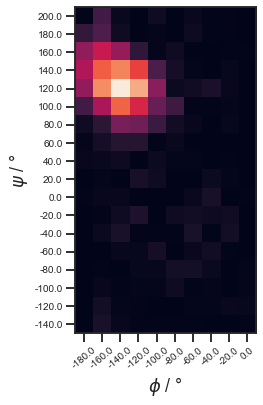

In [273]:
z = np.zeros((18, 1))
q = np.flip(np.flip(distr[:, 10:], axis=1), axis=0)

distr_folded_np = distr[:, :10]+np.concatenate((z, q, z), axis=1)

sns.set_context("talk")
sns.set_style("ticks")

plt.figure(figsize=(6,6))
plt.imshow(np.roll(distr_folded_np, 2, axis=0))
plt.xticks(ticks=np.linspace(0,9,10), labels=np.linspace(-180, 0, 10), fontsize=10, rotation=40)
plt.yticks(ticks=np.linspace(0,17,18), labels=np.flip(np.linspace(-140, 200, 18), axis=0), fontsize=10)

plt.xlabel("$\phi$ / °") 
plt.ylabel("$\psi$ / °")

#### np.save(f'{wdir}/Distributions/{num}{roi_type}_distr_folded_18x10.npy', np.roll(distr_folded_np, 2, axis=0))

plt.show()

# 4. Heterogeneity analysis

<a id='Analysis'></a>

In [204]:
wdir = "C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/" #Folder with 18x10 / 18x18 distributions or folders with TALOS predictions

Definition of Class `rama_map`

In [375]:
class rama_map(object):
    #gridpoint, plot=True, parameters=True
    
    import numpy as np
    import nmrglue as nmr
    np.set_printoptions(precision=3)
    import matplotlib.pyplot as plt
    import seaborn as sns

    from homemade import talos_vis as tl

    def read(self, gridpoint, num, folded=True):
        
        roi_type = assignments.loc[num]['Res'].unique()[0]
        res=f'{num} {roi_type}'
        if gridpoint is None:
            #distr = np.load(f"C:/Users/Krairy/sciebo/Hydrophobin TALOS analysis/Distributions/{num}{roi_type}_distr_18x18.npy")
            distr = np.load(f"{wdir}/Distributions/{num}{roi_type}_distr_18x18.npy") ## Change if moving the notebook
        else:
            gridpoint=int(gridpoint)
            #dic_full = tl.get_working_dic(f'C:/Users/Krairy/sciebo/Hydrophobin TALOS analysis/{num}{roi_type}/{num}{roi_type}_pred_{gridpoint}.tab/predABP.tab')
            dic_full = tl.get_working_dic(f'{wdir}/{num}{roi_type}/{num}{roi_type}_pred_{gridpoint}.tab/predABP.tab') ## Change if moving the notebook
            distr = np.asarray(dic_full[res])
            distr = np.rot90(distr.reshape(18,18), 1)
        
        if folded:
            z = np.zeros((18, 1))
            q = np.flip(np.flip(distr[:, 10:], axis=1), axis=0)
            distr_folded = distr[:, :10]+np.concatenate((z, q, z), axis=1)
            distr_folded = np.roll(distr_folded, 2,axis=0)
            return distr_folded
        else:
            return distr
    
    def parameters(self, distr, folded, verbose):
        
        from scipy import stats, ndimage

        phi_s = np.linspace(-180, 0, 10)
        psi_s = np.flip(np.linspace(-140, 200, 18))  

        if not folded:
            phi_s = np.linspace(-180, 160, 18)                  

        distr_x = distr.ravel()
        phi_mean = np.sum(np.tile(phi_s, 18) * distr_x) / np.sum(distr_x)

        distr_y = distr.T.ravel()
        psi_mean = np.sum(np.tile(psi_s, 10) * distr_y) / np.sum(distr_y)

        c=ndimage.center_of_mass(distr)
        phi_mean = (c[1]-9)*20
        psi_mean = -c[0]*20+200

        distr1 = distr.ravel()
        i = 0
        s = 0 
        for phi in phi_s:
            for psi in psi_s:
                s += ((phi - phi_mean)**2 + (psi - psi_mean)**2 ) * distr1[i] 
                i += 1

        distr1 = distr.ravel()
        s_phi = 0
        i=0
        for phi in np.tile(phi_s, 18):
            s_phi += ((phi - phi_mean)**2 * distr1[i]) 
            i+=1

        distr1 = distr.T.ravel()
        s_psi = 0
        i=0
        for psi in np.tile(psi_s, 10):
            s_psi += ((psi - psi_mean)**2 * distr1[i]) 
            i+=1    

        sigma = np.sqrt(s / distr1.sum())
        sigma_phi = np.sqrt(s_phi / distr1.sum()) #??
        sigma_psi = np.sqrt(s_psi / distr1.sum()) #??

        ## everything is in degrees!
        if verbose:
            print(f'sigma, sigma_phi, sigma_psi, phi_mean, psi_mean\n{sigma, sigma_phi, sigma_psi, phi_mean, psi_mean}')
        return sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
    
    def R(self):    
        template = np.array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        
        distr = self.distr
        distr = distr/distr.sum() # PDF normalied by integral
        extended = np.where(template==1, distr, 0)
        helical = np.where(template==2, distr, 0)
        #if extended.max() > helical.max():
        if extended.sum() > helical.sum():
            return extended.sum()/helical.sum()
        else: 
            return helical.sum()/extended.sum()
    
#    def entropy(self, distr, axis):
#        stats.entropy(distr.sum(axis=axis))
        
    def plot(self, title, save=False): 
        
        from matplotlib.patches import Ellipse
        sns.set_context("poster")
        sns.set_style("ticks")
        
        sigma_phi = self.sigma_phi
        sigma_psi = self.sigma_psi
        phi_mean = self.phi_mean
        psi_mean = self.psi_mean
        distr = self.distr
        
        plt.figure(figsize=(4,6))
        plt.imshow(distr/distr.max(), 
                   extent=(-190, 10, -150, 210), 
                   #cmap='YlGnBu_r', 
                   cmap='Greys_r', vmin=0, vmax=1, 
           #interpolation='bilinear'
                  )
        x_labels = np.linspace(-180, 0, 10)
        y_labels = np.flip(np.linspace(-140, 200, 18), axis=0)
        y_labels[0] = -160
        
        plt.xticks(ticks=np.linspace(-180, 0, 10), labels=x_labels, fontsize=10, rotation=40)
        plt.yticks(ticks=np.flip(np.linspace(-140, 200, 18)), labels=y_labels, fontsize=10)
        #plt.colorbar()
        ellipse = Ellipse((phi_mean, psi_mean), width=sigma_phi*2, height=sigma_psi*2, facecolor='none', edgecolor='y', linewidth=1.3)
        plt.scatter(phi_mean, psi_mean, c='y', s=40, marker='x')
        plt.title(title)
        ax = plt.gca()
        ax.set_xlabel("$\phi$ / °", fontsize=14) 
        ax.set_ylabel("$\psi$ / °", fontsize=14)
        ax.add_patch(ellipse)
        if save:
            plt.gcf().savefig(os.path.join(wdir, f"{self.id}_{title}.png"), format="png", dpi=200)
        plt.show()
        
    def __init__(self, num, gridpoint, path, folded=True, verbose=True, title=None):
        
        ################ from matplotlib.patches import Ellipse # not working if imported here
        if gridpoint is None:
            self.id = 'sum'
        else:
            self.id = gridpoint
        if path is None:   
            self.path = f'C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/{num}{roi_type}/{num}{roi_type}_pred_{gridpoint}.tab/predABP.tab'
        else:
            self.path = path
        self.distr = self.read(gridpoint=gridpoint, num=num, folded=folded)
        distr = self.distr
        self.sigma, self.sigma_phi, self.sigma_psi, self.phi_mean, self.psi_mean = self.parameters(distr, folded=folded, verbose=verbose)
        self.entr_phi = stats.entropy(distr.sum(axis=0))
        self.entr_psi = stats.entropy(distr.sum(axis=1))

In [316]:
residues = [25,26,28,30,34,40,41,42,43,46,53,55,57,63,64,66] # 55 left out for now
cols = np.arange(22,68)
het_params = pd.DataFrame(columns=cols, index=['sigma', 'sigma_phi', 'sigma_psi', 'flatness', 'R', 'H_phi', 'H_psi'])

for num in residues:
    #roi_type = assignments.loc[num]['Res'].unique()[0]
    distr_folded = rama_map(num=num, gridpoint=None, path=None)
    het_params.loc['sigma', num] = distr_folded.sigma
    het_params.loc['sigma_phi', num] = distr_folded.sigma_phi 
    het_params.loc['sigma_psi', num] = distr_folded.sigma_psi 
    het_params.loc['flatness', num] = distr_folded.distr.max()/distr_folded.distr.sum()
    het_params.loc['R', num] = distr_folded.R()
    het_params.loc['sum', num] = distr_folded.distr.sum()
    het_params.loc['H_phi', num] = distr_folded.entr_phi
    het_params.loc['H_psi', num] = distr_folded.entr_psi

sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(122.08817159229497, 36.02261637232183, 104.74283694700631, -86.37638415225271, 11.286347017694254)
sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(132.21803925482675, 42.727189015117055, 99.29844755978846, -129.74524111071435, 79.26745057614599)
sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(144.354079774033, 41.65933304674787, 77.5152090992707, -123.2087997986186, 118.79117825904848)
sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(123.87796728508236, 33.953601002087034, 78.59736802339596, -80.99493875177444, -0.5918677052879673)
sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(135.09501742183272, 35.95509334081775, 69.87598803727185, -119.85080302400976, 101.6176447144828)
sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(122.64020704303762, 49.72062057123083, 103.2428767411244, -115.53975179489203, 55.41941416873772)
sigma, sigma_phi, sigma_psi, phi_mean, psi_mean
(116.3534280036309, 46.602666848381226, 88.10193745977905, -110.44626

Figure save as C:/Users/Admin/sciebo/Hydrophobin TALOS analysis//Results_w_G.png


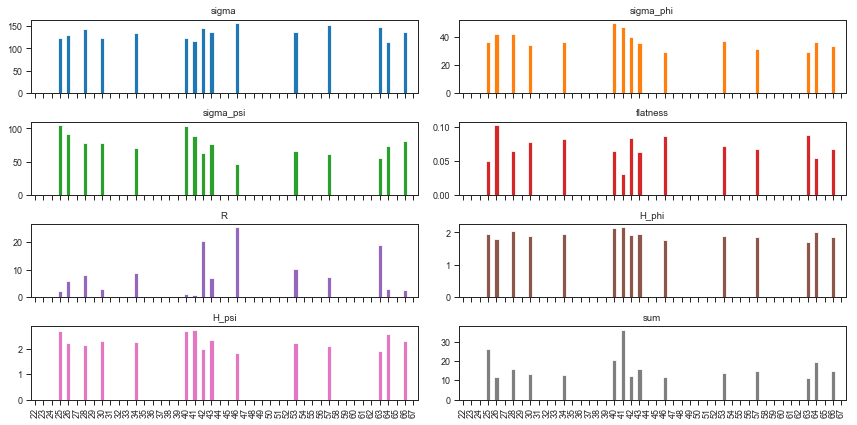

In [199]:
sns.set_context("paper")
sns.set_style("ticks")

indiv_plot_size = 6
het_params.transpose().plot(kind='bar', subplots=True, sharex=True, layout=(4,2), fontsize=9, figsize=(indiv_plot_size*2,indiv_plot_size/4*4), legend=False)
plt.gcf().tight_layout()
plt.gcf().savefig(f'{wdir}/Results_w_G.png', format='png', dpi=300)
print(f"Figure saved as {wdir}/Results_w_G.png")
plt.show()

### Score correction for average uncertainty

In [417]:
tl.get_working_dic(path).keys()

dict_keys(['10 C', '11 S', '12 I', '13 D', '14 D', '15 Y', '16 K', '17 P', '18 Y', '19 C', '20 C', '21 Q', '22 S', '23 M', '24 S', '25 G', '26 S', '27 A', '28 S', '29 L', '30 G', '31 C', '32 V', '33 V', '34 G', '35 V', '36 I', '37 G', '38 S', '39 Q', '40 C', '41 G', '42 A', '43 S', '44 V', '45 K', '46 C', '47 C', '48 K', '49 D', '50 D', '51 V', '52 T', '53 N', '54 T', '55 G', '56 N', '57 S', '58 F', '59 L', '60 I', '61 I', '62 N', '63 A', '64 A', '65 N', '66 C', '67 V'])

In [427]:
predictions = pd.DataFrame(index=pd.MultiIndex.from_product((residues, [0, 1, 2]), names=('ROI #', 'GridPoint #')), columns=['Distr', 'Intensity', 'Sigma_phi', 'Sigma_psi', 'Entr_phi', 'Entr_psi'])

In [333]:
residues = [25,26,30,34,40,41,42,43,46,53,55,57,63,64,66] # 28 left out for now

for num in residues:
    #num = 40
    roi_type = assignments.loc[num]['Res'].unique()[0]
    peak_box = pd.read_csv(os.path.join(wdir, f'PeakShapes/{num}{roi_type}.csv'), sep='\t', index_col=0)
    paths = os.path.join(wdir, f'{num}{roi_type}/*/predABP.tab')
    list_of_experiments = glob.glob(paths)
    
    index = [int(run_id(path)) for path in list_of_experiments]
    predictions = pd.DataFrame(##index=pd.MultiIndex.from_product((residues, np.arange(len(list_of_experiments))), names=('ROI #', 'GridPoint #'))
                             index=index, columns=['Distr', 'Intensity', 'Sigma_phi', 'Sigma_psi', 'Entr_phi', 'Entr_psi', 'flatness', 'R', 'phi_mean', 'psi_mean'])
    
        #dic = tl.get_working_dic(list_of_experiments[0])

    for path in list_of_experiments:
        pred_id = int(run_id(path))
        run = rama_map(num=num, gridpoint=pred_id, path=path, verbose=False)
        predictions.loc[pred_id, 'Distr'] = run.distr
        predictions.loc[pred_id, 'Intensity'] = peak_box.loc[pred_id, "Intensity"] ## Lookup number of TALOS run and find intensity of the corresponding point 
        predictions.loc[pred_id, 'Sigma_phi'] = run.sigma_phi
        predictions.loc[pred_id, 'Sigma_psi'] = run.sigma_psi
        predictions.loc[pred_id, 'Entr_phi'] = run.entr_phi
        predictions.loc[pred_id, 'Entr_psi'] = run.entr_psi
        predictions.loc[pred_id, 'flatness'] = np.round(run.distr.max()/run.distr.sum(), 4)
        predictions.loc[pred_id, 'R'] = run.R()
        predictions.loc[pred_id, 'phi_mean'] = run.phi_mean
        predictions.loc[pred_id, 'psi_mean'] = run.psi_mean
        predictions['Weight'] = predictions['Intensity'] /  predictions['Intensity'].sum()

    predictions.to_csv(os.path.join(wdir, f'Distributions/{num}{roi_type}.csv'), sep="\t")

In [337]:
residues = [25,26,30,34,40,41,42,43,46,53,57,63,64,66] # 28 left out for now

for num in residues:
    roi_type = assignments.loc[num]['Res'].unique()[0]
    predictions = pd.read_csv(os.path.join(wdir, f'Distributions/{num}{roi_type}.csv'), sep="\t")
    het_params.loc['sigma_phi_corr', num] = het_params.loc['sigma_phi', num] - (predictions['Sigma_phi'] * predictions['Intensity']).sum() / predictions['Intensity'].sum()
    het_params.loc['sigma_psi_corr', num] = het_params.loc['sigma_psi', num] - (predictions['Sigma_psi'] * predictions['Intensity']).sum() / predictions['Intensity'].sum()
    het_params.loc['H_phi_corr', num] = het_params.loc['H_phi', num] - (predictions['Entr_phi'] * predictions['Intensity']).sum() / predictions['Intensity'].sum()
    het_params.loc['H_psi_corr', num] = het_params.loc['H_psi', num] - (predictions['Entr_phi'] * predictions['Intensity']).sum() / predictions['Intensity'].sum()
    het_params.loc['Flat_corr', num] = het_params.loc['flatness', num] - (predictions['Entr_phi'] * predictions['Intensity']).sum() / predictions['Intensity'].sum()
    het_params.loc['StErrMean_phi', num] = np.sqrt(np.sum((predictions['phi_mean'] - predictions['phi_mean'].mean() )**2 * predictions['Weight'] ) / (predictions['Weight'].sum()) )
    het_params.loc['StErrMean_psi', num] = np.sqrt(np.sum((predictions['psi_mean'] - predictions['psi_mean'].mean() )**2 * predictions['Weight'] ) / (predictions['Weight'].sum()) )
het_params.to_csv(os.path.join(wdir, f'Heterogeneity.csv'), sep="\t")

Figure saved as C:/Users/Admin/sciebo/Hydrophobin TALOS analysis//Results_w_G_corrected_1.png


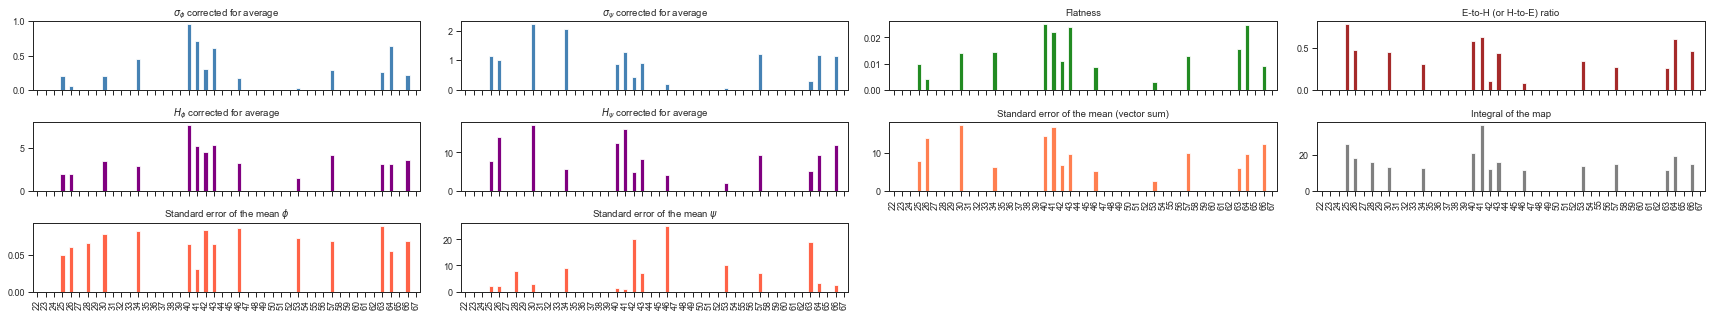

In [356]:
sns.set_context("paper")
sns.set_style("ticks")

#het_params[55]=None

indiv_plot_size = 6
nrows = 3
ncols = 4

het_params.loc['StErrMean'] = (het_params.loc['StErrMean_phi']**2 + het_params.loc['StErrMean_psi']**2)**0.5
het_params.transpose()[["sigma_phi_corr", "sigma_psi_corr", 'H_phi_corr', 'H_psi_corr', 'StErrMean_phi', 'StErrMean_psi', 'StErrMean', 'sum', 'flatness', 'R']].plot(kind='bar', 
                        title=["$\sigma_{\phi}$ corrected for average", "$\sigma_{\psi}$ corrected for average", 'Flatness', 'E-to-H (or H-to-E) ratio',
                               '$H_{\phi}$ corrected for average', '$H_{\psi}$ corrected for average', 'Standard error of the mean (vector sum)', 'Integral of the map', 
                               'Standard error of the mean $\phi$', 'Standard error of the mean $\psi$' ], 
                        color=['steelblue', 'steelblue', 'forestgreen', 'brown', 
                              'purple', 'purple', 'coral', 'gray', 
                              'tomato', 'tomato'],
                        subplots=True, sharex=True, layout=(nrows, ncols), fontsize=9, figsize=(indiv_plot_size*ncols,indiv_plot_size/4*nrows), legend=False)
plt.gcf().tight_layout()
plt.gcf().savefig(f'{wdir}/Results_w_G_corrected_1.png', format='png', dpi=300)
print(f"Figure saved as {wdir}/Results_w_G_corrected_1.png")
plt.show()

In [343]:
het_params.columns

Int64Index([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
            56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
           dtype='int64')

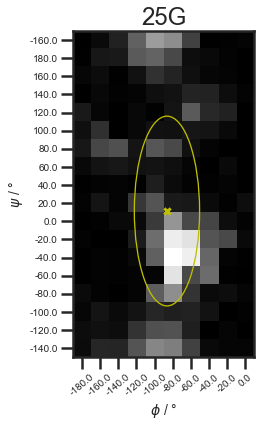

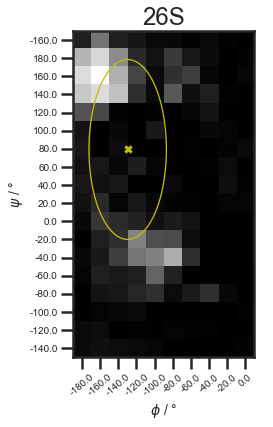

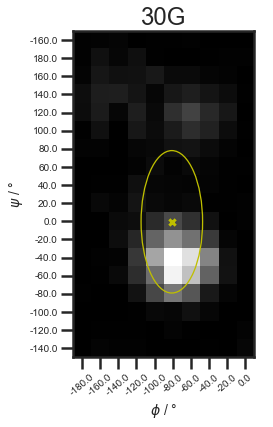

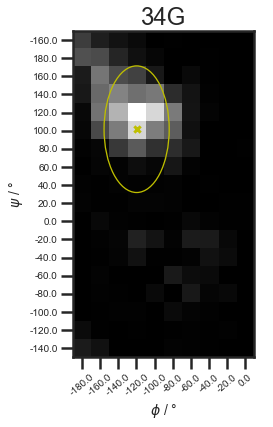

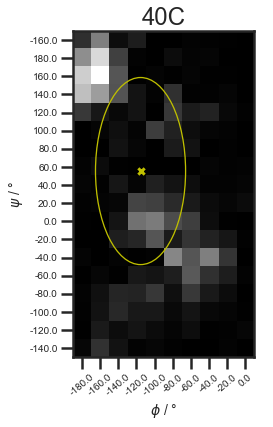

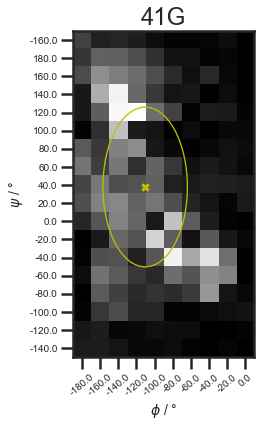

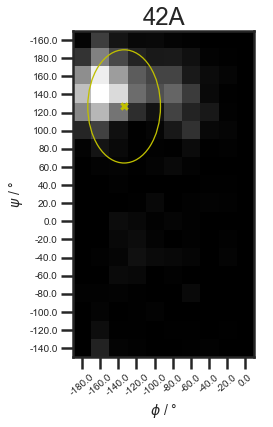

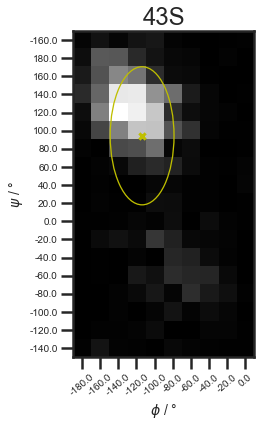

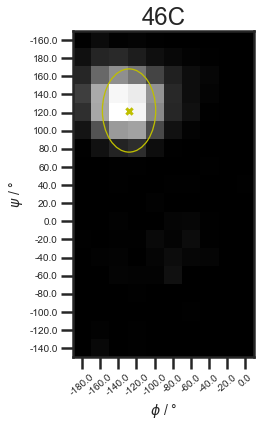

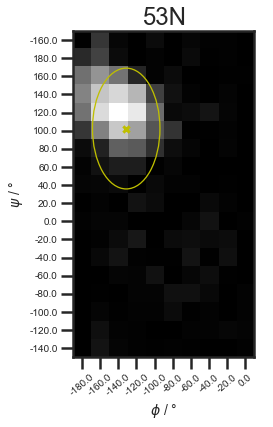

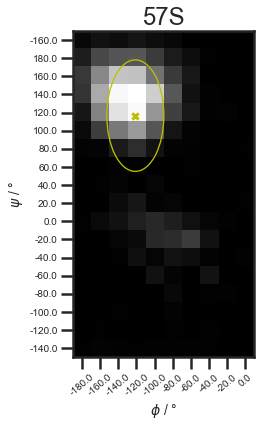

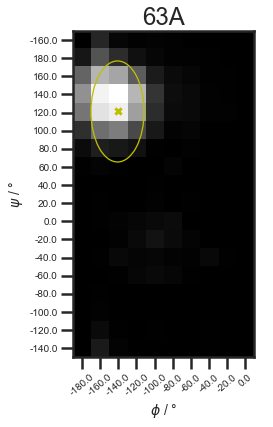

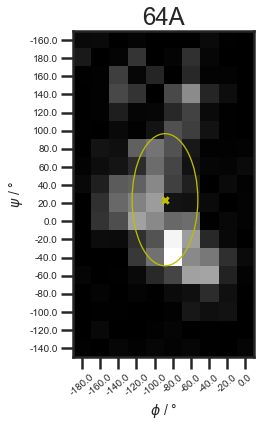

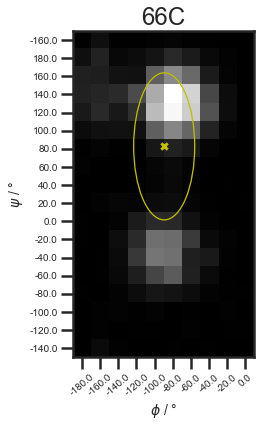

In [376]:
for num in residues:
    roi_type = assignments.loc[num]['Res'].unique()[0]
    #path = f'C:\\Users\\Admin\\sciebo\\Hydrophobin TALOS analysis\\Distributions\\{num}{roi_type}_distr_folded_18x10.npy'
    rama = rama_map(num=num, gridpoint=None, path=None, verbose=False)
    rama.plot(title=f"{num}{roi_type}", save=True)

R is calculated as the ratio of the sums of these two areas:


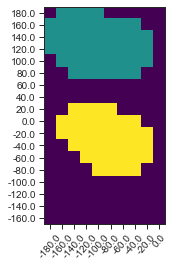

In [410]:
def parameters(distr, folded=True, verbose=True):
    
    # in degrees
    
    phi_s = np.linspace(-180, 0, 10)
    psi_s = np.flip(np.linspace(-140, 200, 18))  
    
    if not folded:
        phi_s = np.linspace(-180, 160, 18)                  

    distr_x = distr.ravel()
    phi_mean = np.sum(np.tile(phi_s, 18) * distr_x) / np.sum(distr_x)
    
    distr_y = distr.T.ravel()
    psi_mean = np.sum(np.tile(psi_s, 10) * distr_y) / np.sum(distr_y)
    
    c = center_of_mass(distr)
    phi_mean = (c[1]-9)*20
    psi_mean = -c[0]*20+200

    distr1 = distr.ravel()
    i = 0
    s = 0 
    for phi in phi_s:
        for psi in psi_s:
            s += ((phi - phi_mean)**2 + (psi - psi_mean)**2 ) * distr1[i] 
            i += 1
    
    distr1 = distr.ravel()
    s_phi = 0
    i=0
    for phi in np.tile(phi_s, 18):
        s_phi += ((phi - phi_mean)**2 * distr1[i]) 
        i+=1
    
    distr1 = distr.T.ravel()
    s_psi = 0
    i=0
    for psi in np.tile(psi_s, 10):
        s_psi += ((psi - psi_mean)**2 * distr1[i]) 
        #print(psi, '\t', psi - psi_mean, '\t', distr1[i], '\t', s_psi)
        #print(s_psi)
        #print()
        i+=1    
            
    sigma = np.sqrt(s / distr1.sum())
    sigma_phi = np.sqrt(s_phi / distr1.sum()) #??
    sigma_psi = np.sqrt(s_psi / distr1.sum()) #??
    
    # flatness
    flatness = np.max(distr)/np.sum(distr)
    
    ## everything is in degrees!
    if verbose:
        print(f'sigma, sigma_phi, sigma_psi, phi_mean, psi_mean, flatness\n{sigma, sigma_phi, sigma_psi, phi_mean, psi_mean, flatness}')
    return sigma, sigma_phi, sigma_psi, phi_mean, psi_mean, flatness

#def sigma_phi()

template = np.array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

def R(distr, template=template):    
    distr = distr/distr.sum() # PDF normalied by integral
    extended = np.where(template==1, distr, 0)
    helical = np.where(template==2, distr, 0)
    if extended.max() > helical.max():
        return extended.sum()/helical.sum()
    else: 
        return helical.sum()/extended.sum()
    
plt.imshow(template, cmap='viridis', extent=(-190, 10, -170, 190))
plt.xticks(np.linspace(-180, 0, 10), labels=np.linspace(-180, 0, 10), fontsize=10, rotation=49)
plt.yticks(np.linspace(-160, 180, 18), labels=np.linspace(-160, 180, 18), fontsize=10)
print('R is calculated as the ratio of the sums of these two areas:')
plt.show()